<a href="https://colab.research.google.com/github/ZoeMcFife/5AHITM/blob/main/INSY/Colab/%232025-03-06%23/KNN-Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Voter classification using exit poll data

*This is based on the course of [Fraida Fund](https://colab.research.google.com/github/ffund/ml-notebooks/blob/master/notebooks/1-colab-tour.ipynb) for  NYU Tandon School of Engineering*

**TODO**: Edit this cell to fill in your name:

-   **Name**: Bunea

In this notebook, we will explore the problem of voter classification.

Given demographic data about a voter and their opinions on certain key issues, can we predict their vote in the 2016 U.S. presidential election? We will attempt this using a K nearest neighbor classifier.

In the first few sections of this notebook, I will show you how to prepare the data and and use a K nearest neighbors classifier for this task, including:

-   getting the data and loading it into the workspace.
-   preparing the data: dealing with missing data, encoding categorical data in numeric format, and splitting into training and test.

In the last few sections of the notebook, you will have to improve the basic model for better performance, using a custom distance metric and using feature selection or feature weighting. In these sections, you will have specific criteria to satisfy for each task.

**However, you should also make sure your overall solution is good!** An excellent solution to this problem will achieve greater than 80% validation accuracy. A great solution will achieve 75% or higher.

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

np.set_printoptions(suppress=True)

## Load data

The data for this notebook comes from the [U.S. National Election Day Exit Polls](https://ropercenter.cornell.edu/exit-polls/us-national-election-day-exit-polls).

Here’s a brief description of how exit polls work.

Exit polls are conducted by Edison Research on behalf of a consortium of media organizations.

First, the member organizations decide what races to cover, what sample size they want, what questions should be asks, and other details. Then, sample precincts are selected, and local interviewers are hired and trained. Then, at those precincts, the local interviewer approaches a subset of voters as they exit the polls (for example, every third voter, or every fifth voter, depending on the required sample size).

When a voter is approached, they are asked if they are willing to fill out a questionnaire. Typically about 40-50% agree. (For those that decline, the interviewer visually estimates their age, race, and gender, and notes this information, so that the response rate by demographic is known and responses can be weighted accordingly in order to be more representative of the population.)

Voters that agree to participate are then given an form with 15-20 questions. They fill in the form (anonymously), fold it, and put it in a small ballot box.

Three times during the day, the interviewers will stop, take the questionnaires, compile the results, and call them in to the Edison Research phone center. The results are reported immediately to the media organizations that are consortium members.

In addition to the poll of in-person voters, absentee and early voters (who are not at the polls on Election Day) are surveyed by telephone.

### Download the data and documentation

The exit poll data is not freely available on the web, but you can download the dataset on Moodle.

### Upload into Colab filesystem

To get the data into Colab, run the following cell. Upload the CSV file you just downloaded (`31116396_National2016.csv`) to your Colab workspace. Wait until the uploaded has **completely** finished - it may take a while, depending on the quality of your network connection.

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 31116396_National2016.csv to 31116396_National2016.csv
User uploaded file "31116396_National2016.csv" with length 26258607 bytes


### Load data with pandas

Now, use the `read_csv` function in `pandas` to read in the file.

Also use `head` to view the first few rows of data and make sure that everything is read in correctly.

In [5]:
df = pd.read_csv('31116396_National2016.csv')
df.head()

<ipython-input-5-d2daf1675d09>:1: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('31116396_National2016.csv')


,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,...,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
0,135355,Hillary Clinton,The Democratic candidate,6.530935,,18-29,18-29,18-24,18-44,18-49,...,,,,Version 1,,,No,,,
1,135356,Hillary Clinton,The Democratic candidate,6.479016,,18-29,18-29,25-29,18-44,18-49,...,,,,Version 1,,,No,,,
2,135357,Hillary Clinton,The Democratic candidate,8.493230,,30-44,30-59,30-39,18-44,18-49,...,,,,Version 1,,,No,,,
3,135358,Hillary Clinton,The Democratic candidate,3.761814,,30-44,30-59,30-39,18-44,18-49,...,,,,Version 1,,,No,,,
4,135359,Hillary Clinton,The Democratic candidate,3.470473,,45-65,30-59,45-49,45+,18-49,...,,,,Version 1,,,No,,,


## Prepare data

Survey data can be tricky to work with, because surveys often “branch”; the questions that are asked depends on a respondent’s answers to other questions.

In this case, different respondents fill out different versions of the survey. Review pages 7-11 of the “Study Documentation, Questionnaire, and Codebooks” PDF file you downloaded earlier, which shows the five different questionnaire versions used for the 2016 exit polls.

Note that in a red box next to each question, you can see the name of the variable (column name) that the respondent’s answer will be stored in.

<figure>
<img src="https://raw.githubusercontent.com/ffund/ml-notebooks/master/notebooks/images/exit-poll-survey-versions.png" alt="Exit poll versions" />
<figcaption aria-hidden="true">Exit poll versions</figcaption>
</figure>

This cell will tell us how many respondents answered each version of the survey:

In [6]:
df['VERSION'].value_counts()

,count
VERSION,
Version 2,5126
Version 1,5094
Version 3,4980
Version 4,4919
Version 5,4915


Because each respondent answers different questions, for each row in the data, only some of the columns - the columns corresponding to questions included in that version of the survey - have data. Our classifier will need to handle that.

You may also notice that the data is *categorical*, not *numeric* - for each question, users choose their response from a finite set of possible answers. We will need to convert this type of data into something that our classifier can work with.

### Label missing data

Since each respondent only saw a subset of questions, we expect to see missing values in each column.

However, if we look at the **count** of values in each column, we see that there are no missing values - every column has the full count!

In [7]:
df.describe(include='all')

,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,...,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
count,25034.000000,25034,25034,25034.000000,25034,25034,25034,25034,25034,25034,...,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034
unique,NaN,7,5,NaN,5,5,4,9,3,3,...,6,4,3,5,3,7,3,3,3,4
top,NaN,Hillary Clinton,The Democratic candidate,NaN,,45-65,30-59,50-59,45+,18-49,...,,,,Version 2,,,,,,
freq,NaN,12126,12041,NaN,15568,9746,13697,5071,14436,12836,...,20284,20284,20324,5126,20387,16441,15521,20137,20503,22181
mean,188663.858712,NaN,NaN,1.003016,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,27829.369563,NaN,NaN,1.065169,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,135355.000000,NaN,NaN,0.047442,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,175885.250000,NaN,NaN,0.525367,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,193824.500000,NaN,NaN,0.745491,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,210374.500000,NaN,NaN,1.031137,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This is because missing values are recorded as a single space, and not with a NaN.

Let’s change that:

In [8]:
df.replace(" ", float("NaN"), inplace=True)

Now we can see an accurate count of the number of responses in each column:

In [9]:
df.describe(include='all')

,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,...,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
count,25034.000000,24696,23970,25034.000000,9466,24853,24853,24853,24853,24853,...,4750,4750,4710,25034,4647,8593,9513,4897,4531,2853
unique,NaN,6,4,NaN,4,4,3,8,2,2,...,5,3,2,5,2,6,2,2,2,3
top,NaN,Hillary Clinton,The Democratic candidate,NaN,Hillary Clinton,45-65,30-59,50-59,45+,18-49,...,A lot,A lot or some,No,Version 2,No,White Protestants,No,All others,No,All others
freq,NaN,12126,12041,NaN,4611,9746,13697,5071,14436,12836,...,2481,3424,3771,5126,4040,3038,8136,3627,3605,1357
mean,188663.858712,NaN,NaN,1.003016,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,27829.369563,NaN,NaN,1.065169,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,135355.000000,NaN,NaN,0.047442,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,175885.250000,NaN,NaN,0.525367,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,193824.500000,NaN,NaN,0.745491,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,210374.500000,NaN,NaN,1.031137,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notice that *every* row has some missing data! If we drop the rows with missing values, we’re left with an empty data frame (0 rows):

In [10]:
df.dropna()

,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,...,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3


Instead, we’ll have to make sure that the classifier we use is able to work with partial data. One nice benefit of K nearest neighbors is that it can work well with data that has missing values, as long as we use a distance metric that behaves reasonably under these conditions.

### Encode target variable as a binary variable

Our goal is to classify voters based on their vote in the 2016 presidential election, i.e. the value of the `PRES` column. We will restrict our attention to the candidates from the two major parties, so we will throw out the rows representing voters who chose other candidates:

In [11]:
df = df[df['PRES'].isin(['Donald Trump', 'Hillary Clinton'])]
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22798 entries, 0 to 22797
Columns: 138 entries, ID to WPROTBRN3
dtypes: float64(1), int64(2), object(135)
memory usage: 24.0+ MB


In [12]:
df['PRES'].value_counts()

,count
PRES,
Hillary Clinton,12126
Donald Trump,10672


Now, we will transform the string value into a binary variable, and save the result in `y`. We will build a binary classifier that predicts `1` if it thinks a sample is Trump voter, and `0` if it thinks a sample is a Clinton voter.

In [13]:
y = df['PRES'].map({'Donald Trump': 1, 'Hillary Clinton': 0})
y.value_counts()

,count
PRES,
0,12126
1,10672


### Encode ordinal features

Next, we need to encode our features. All of the features are represented as strings, but we will have to transform them into something over which we can compute a meaningful distance measure.

Columns that have a **logical order** should be encoded using ordinal encoding, so that the distance metric will be meaningful.

For example, consider the `AGE` column, in which users select an option from the following:

In [14]:
df['AGE'].unique()

array(['18-29', '30-44', '45-65', '65+', nan], dtype=object)

What if we transform the `AGE` column using four binary columns: `AGE_18-29`, `AGE_30-44`, `AGE_45-65`, `AGE_65+`, with a 0 or a 1 in each column to indicate the respondent’s age?

If we did this, we would lose meaningful information about the distance between ages; a respondent whose age is 18-29 would have the same distance to one whose age is 45-65 as to one whose age is 65+. Logically, we expect that a respondent whose age is 18-29 is most similar to the other 18-29 respondents, less similar to the 30-44 respondents, even less similar to the 45-65 respondents, and least similar to the 65+ respondents.

To realize this, we will use **ordinal encoding**, which will represent `AGE` in a single column with *ordered* integer values.

First, we define a dictionary that maps each possible value to an integer.

In [15]:
mapping_dict_age = {'18-29': 1,
                 '30-44': 2,
                 '45-65': 3,
                 '65+': 4}

Then we can create a new data frame, `df_enc_ord`, by calling `map` on the original `df['AGE']` and passing this mapping dictionary. We will also specify that the index should be the same as the original data frame:

In [16]:
df_enc_ord = pd.DataFrame( {'AGE': df['AGE'].map( mapping_dict_age) },
    index = df.index
)

We can extend this approach to encode more than one ordinal feature. For example, let us consider the column `EDUC12R`, which includes the respondent’s answer to the question:

> Which best describes your education?
>
> 1.  High school or less
> 2.  Some college/assoc. degree
> 3.  College graduate
> 4.  Postgraduate study

In [17]:
df['EDUC12R'].value_counts()

,count
EDUC12R,
Some college/assoc. degree,7134
College graduate,6747
Postgraduate study,4071
High school or less,3846


We can map both `AGE` and `EDUC12R` to ordinal-encoded columns in a new data frame:

In [18]:
mapping_dict_age = {'18-29': 1,
                 '30-44': 2,
                 '45-65': 3,
                 '65+': 4}
mapping_dict_educ12r =  {'High school or less': 1,
                   'Some college/assoc. degree': 2,
                   'College graduate': 3,
                   'Postgraduate study': 4}
df_enc_ord = pd.DataFrame( {
    'AGE': df['AGE'].map( mapping_dict_age) ,
    'EDUC12R': df['EDUC12R'].map( mapping_dict_educ12r)
    },
    index = df.index
)

Note that the order matters - the “High school or less” answer should have the smallest value, followed by “Some college/assoc. degree”, then “College graduate”, then “Postgraduate study”.

Also note that missing values are still treated as missing (not mapped to some value) - this is going to be important, since we are going to design a distance metric that treats missing values sensibly:

In [19]:
df_enc_ord.isna().sum()

,0
AGE,158
EDUC12R,1000


There’s one more important step before we can use our ordinal-encoded values with KNN.

Note that the values in the encoded columns range from 1 to the number of categories. For K nearest neighbors, the “importance” of each feature in determining the class label would be proportional to its scale (because the value of the feature is used directly in the distance metric). If we leave it as is, any feature with a larger range of possible values will be considered more “important!”, i.e. would count more in the distance metric.

So, we will re-scale our encoded features to the unit interval. We can do this with the `MinMaxScaler` in `sklearn`.

(Note: in general, you’d “fit” scalers etc. on only the training data, not the test data! In this case, however, the min and max in the training data is just due to our encoding, and will definitely be the same as the test data, so it doesn’t really matter.)

In [20]:
scaler = MinMaxScaler()

# first scale in numpy format, then convert back to pandas df
df_scaled = scaler.fit_transform(df_enc_ord)
df_enc_ord = pd.DataFrame(df_scaled, columns=df_enc_ord.columns)

In [21]:
df_enc_ord.describe()

,AGE,EDUC12R
count,22640.000000,21798.000000
mean,0.542609,0.502202
std,0.323963,0.329376
min,0.000000,0.000000
25%,0.333333,0.333333
50%,0.666667,0.333333
75%,0.666667,0.666667
max,1.000000,1.000000


In [22]:
df_enc_ord['EDUC12R'].value_counts()

,count
EDUC12R,
0.333333,7134
0.666667,6747
1.000000,4071
0.000000,3846


In [23]:
df_enc_ord.isna().sum()

,0
AGE,158
EDUC12R,1000


Later, you’ll design a model with more ordinal features. For this initial demo, though, we’ll stick to just those two - age and education - and continue to the next step.

### Encode categorical features

In the previous section, we encoded features that have a logical ordering.

Other categorical features, such as `RACE`, have no logical ordering. It would be wrong to assign an ordered mapping to these features. These should be encoded using **one-hot encoding**, which will create a new column for each unique value, and then put a 1 or 0 in each column to indicate the respondent’s answer.

(Note: for features that have two possible values - binary features - either categorical encoding or one-hot encoding would be valid in this case!)

In [24]:
df['RACE'].value_counts()

,count
RACE,
White,15918
Black,2993
Hispanic/Latino,2210
Asian,686
Other,681


We can one-hot encode this column using the `get_dummies` function in `pandas`.

In [25]:
df_enc_oh = pd.get_dummies(df['RACE'], prefix='RACE' )

In [26]:
df_enc_oh.describe()

,RACE_Asian,RACE_Black,RACE_Hispanic/Latino,RACE_Other,RACE_White
count,22798,22798,22798,22798,22798
unique,2,2,2,2,2
top,False,False,False,False,True
freq,22112,19805,20588,22117,15918


Note that we added a `RACE` prefix to each column name - this prevents overlap between columns, e.g. if we also encoded another feature where “Other” was a possible answer. And, it helps us relate the new columns back to the original survey question that they answer.

For this survey data, we want to preserve information about missing values - if a sample did not have a value for the `RACE` feature, we want it to have a NaN in all `RACE` columns. We can assign NaN to those rows as follows:

In [27]:
df_enc_oh.loc[df['RACE'].isnull(), df_enc_oh.columns.str.startswith("RACE_")] = float("NaN")

<ipython-input-27-ecbd6d6dec79>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_enc_oh.loc[df['RACE'].isnull(), df_enc_oh.columns.str.startswith("RACE_")] = float("NaN")
<ipython-input-27-ecbd6d6dec79>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_enc_oh.loc[df['RACE'].isnull(), df_enc_oh.columns.str.startswith("RACE_")] = float("NaN")
<ipython-input-27-ecbd6d6dec79>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_enc_oh.loc[df['RACE'].isnull(), df_enc_o

Now, for respondents where this feature is not available, we have a NaN in all `RACE` columns:

In [28]:
df_enc_oh.isnull().sum()

,0
RACE_Asian,310
RACE_Black,310
RACE_Hispanic/Latino,310
RACE_Other,310
RACE_White,310


### Stack columns

Now, we’ll prepare our feature data, by column-wise concatenating the ordinal-encoded feature columns and the one-hot-encoded feature columns:

In [29]:
X = pd.concat([df_enc_oh, df_enc_ord], axis=1)

### Get training and test indices

We’ll be working with many different subsets of this dataset, including different columns.

So instead of splitting up the data into training and test sets, we’ll get an array of training indices and an array of test indices using `ShuffleSplit`. Then, we can use these arrays throughout this notebook.

In [30]:
idx_tr, idx_ts = next(ShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 3).split(df['PRES']))

I specified the state of the random number generator for repeatability, so that every time we run this notebook we’ll have the same split. This makes it easier to discuss specific examples.

Now, we can use the `pandas` function `.iloc` to get the training and test parts of the data set for any column.

For example, if we want the training subset of `y`:

In [31]:
y.iloc[idx_tr]

,PRES
1349,1
14642,0
18106,0
19171,1
17962,0
...,...
6400,1
15288,0
11513,0
1688,1


or the test subset of `y`:

In [32]:
y.iloc[idx_ts]

,PRES
21876,1
17297,0
19295,0
8826,1
11357,0
...,...
9144,0
4409,0
6320,0
7824,0


Here are the summary statistics for the training data:

In [33]:
X.iloc[idx_tr].describe()

,AGE,EDUC12R
count,15846.000000,15261.000000
mean,0.541398,0.503396
std,0.324832,0.329551
min,0.000000,0.000000
25%,0.333333,0.333333
50%,0.666667,0.333333
75%,0.666667,0.666667
max,1.000000,1.000000


## Train a k nearest neighbors classifier

Now that we have a target variable, a few features, and training and test indices, let’s see what happens if we try to train a K nearest neighbors classifier.

### Baseline: “prediction by mode”

As a baseline against which to judge the performance of our classifier, let’s find out the accuracy of a classifier that gives the majority class label (0) to all samples in our test set:

In [34]:
y_pred_baseline = np.repeat(0, len(y.iloc[idx_ts]))
accuracy_score(y.iloc[idx_ts], y_pred_baseline)

0.5321637426900585

A classifier trained on the data should do *at least* as well as the one that predicts the majority class label. Hopefully, we’ll be able to do much better!

### `KNeighborsClassifier` does not support data with NaNs

We’ve previously seen the `sklearn` implementation of a `KNeighborsClassifier`. However, that won’t work for this problem. If we try to train a `KNeighborsClassifier` on our data using the default settings, it will fail with the error message

    ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

See for yourself:

In [35]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X.iloc[idx_tr], y.iloc[idx_tr])


ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

This is because we have many missing values in our data. And, as we explained previously, dropping rows with missing values is not a good option for this example.

Although we cannot use the `sklearn` implementation of a `KNeighborsClassifier`, we can write our own. We need a few things:

-   a function that implements a distance metric
-   a function that accepts a distance matrix and returns the indices of the K smallest values for each row
-   a function that returns the majority vote of the training samples represented by those indices

and we have to be prepared to address complications at each stage!

### Distance metric

Let’s start with the distance metric. Suppose we use an L1 distance computed over the features that are non-NaN for both samples:

In [36]:
def custom_distance(a, b):
  dif = np.abs(np.subtract(a,b))    # element-wise absolute difference
  # dif will have NaN for each element where either a or b is NaN
  l1 = np.nansum(dif, axis=1)  # sum of differences, treating NaN as 0
  return l1

The function above expects a vector for the first argument and a matrix for the second argument, and returns a vector.

For example: suppose you pass a test point $x_t$ and a matrix of training samples where each row $x_0, \ldots, x_n$ is another training sample. It will return a vector $d_t$ with as many elements as there are training samples, and where the $i$th entry is the distance between the test point $x_t$ and training sample $x_i$.

To see how to this function is used, let's consider an example with a small number of test samples and training samples.

Suppose we had this set of test data `a` (sampling some specific examples from the real data):

In [37]:
a_idx = np.array([10296, 510,4827,20937, 22501])
a = X.iloc[a_idx]
a

,RACE_Asian,RACE_Black,RACE_Hispanic/Latino,RACE_Other,RACE_White,AGE,EDUC12R
10296,False,False,False,False,True,0.666667,0.666667
510,False,False,False,False,True,1.000000,0.666667
4827,False,False,False,False,True,0.666667,0.333333
20937,False,True,False,False,False,0.333333,0.333333
22501,NaN,NaN,NaN,NaN,NaN,0.666667,1.000000


and this set of training data `b`:

In [38]:
b_idx = np.array([10379, 4343, 7359,  1028,  2266, 131, 11833, 14106,  6682,  4402, 11899,  5877, 11758, 13163])
b = X.iloc[b_idx]
b

,RACE_Asian,RACE_Black,RACE_Hispanic/Latino,RACE_Other,RACE_White,AGE,EDUC12R
10379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4343,True,False,False,False,False,0.666667,0.666667
7359,False,False,False,False,True,0.000000,0.000000
1028,False,True,False,False,False,1.000000,0.000000
2266,False,False,False,False,True,1.000000,0.666667
131,NaN,NaN,NaN,NaN,NaN,1.000000,0.666667
11833,False,False,False,False,True,1.000000,0.000000
14106,False,False,False,False,True,0.000000,0.666667
6682,False,False,False,False,True,1.000000,0.000000
4402,False,False,False,False,True,0.333333,0.666667


We need to compute the distance from each sample in the test data `a`, to each sample in the training data `b`.

We will set up a *distance matrix* in which to store the results. In the distance matrix, an entry in row $i$, column $j$ represents the distance between row $i$ of the test set and row $j$ of the training set.

So the distance matrix should have as many rows as there are test samples, and as many columns as there are training samples.

In [39]:
distances_custom = np.zeros(shape=(len(a_idx), len(b_idx)))
distances_custom.shape


(5, 14)

Now that we have the distance matrix set up, we’re ready to fill it in with distance values. We will loop over each sample in the test set, and call the distance function passing that test sample and the entire training set.

Instead of a conventional `for` loop, we will use a [tqdm](https://github.com/tqdm/tqdm) `for` loop. This library conveniently “wraps” the conventional `for` loop with a progress part, so we can see our progress while the loop is running.

In [40]:
# the first argument to tqdm, range(len(a_idx)), is the list we are looping over
for idx in tqdm(range(len(a_idx)),  total=len(a_idx), desc="Distance matrix"):
  distances_custom[idx] = custom_distance(X.iloc[a_idx[idx]].values, X.iloc[b_idx].values)

Distance matrix: 100%|██████████| 5/5 [00:00<00:00, 1421.99it/s]


Let’s look at those distances now:

In [41]:
np.set_printoptions(precision=2) # show at most 2 decimal places
print(distances_custom)

[[0.   2.   1.33 3.   0.33 0.33 1.   0.67 1.   0.33 0.67 2.67 2.   2.  ]
 [0.   2.33 1.67 2.67 0.   0.   0.67 1.   0.67 0.67 1.   3.   2.33 2.33]
 [0.   2.33 1.   2.67 0.67 0.67 0.67 1.   0.67 0.67 0.33 2.67 2.33 2.33]
 [0.   2.67 2.67 1.   3.   1.   3.   2.67 3.   2.33 2.67 2.33 0.67 0.67]
 [0.   0.33 1.67 1.33 0.67 0.67 1.33 1.   1.33 0.67 1.   0.67 0.33 0.33]]


### Find most common class of k nearest neighbors

Now that we have this distance matrix, for each test sample, we can:

-   get an array of indices from the *distance matrix*, sorted in order of increasing distance
-   get the list of the K nearest neighbors as the first K elements from that list,
-   from those entries - which are indices with respect to the distance matrix - get the corresponding indices in `X` and `y`,
-   and then predict the class of the test sample as the most common value of `y` among the nearest neighbors.

In [42]:
k = 3
# array of indices sorted in order of increasing distance
distances_sorted = np.array([np.argsort(row) for row in distances_custom])
# first k elements in that list = indices of k nearest neighbors
nn_lists = distances_sorted[:, :k]
# map indices in distance matrix back to indices in `X` and `y`
nn_lists_idx = b_idx[nn_lists]
# for each test sample, get the mode of `y` values for the nearest neighbors
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

### Example: one test sample

For example, this was the first test sample:

In [43]:
X.iloc[[10296]]

,RACE_Asian,RACE_Black,RACE_Hispanic/Latino,RACE_Other,RACE_White,AGE,EDUC12R
10296,False,False,False,False,True,0.666667,0.666667


Here is its distance to each of the training samples in our “mini” training set:

In [44]:
distances_custom[0]

array([0.  , 2.  , 1.33, 3.  , 0.33, 0.33, 1.  , 0.67, 1.  , 0.33, 0.67,
       2.67, 2.  , 2.  ])

and here’s the sorted list of indices from that distance matrix - i.e. the index of the training sample with the smallest distance, the index of the training sample with the second-smallest distance, and so on.

In [45]:
distances_sorted[0]

array([ 0,  4,  5,  9,  7, 10,  6,  8,  2,  1, 12, 13, 11,  3])

The indices (in the “mini” training sample) of the 3 nearest neighbors to this test sample are:

In [46]:
nn_lists[0]

array([0, 4, 5])

which corresponds to the following sample indices in the complete data `X`:

In [47]:
nn_lists_idx[0]

array([10379,  2266,   131])

So, its closest neighbors in the “mini” training set are:

In [48]:
X.iloc[nn_lists_idx[0]]

,RACE_Asian,RACE_Black,RACE_Hispanic/Latino,RACE_Other,RACE_White,AGE,EDUC12R
10379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2266,False,False,False,False,True,1.0,0.666667
131,NaN,NaN,NaN,NaN,NaN,1.0,0.666667


and their corresponding values in `y` are:

In [49]:
y.iloc[nn_lists_idx[0]]

,PRES
10379,1
2266,0
131,1


and so the predicted label for the first test sample would be:

In [50]:
y.iloc[nn_lists_idx[0]].mode().values

array([1])

### Example: entire test set

Now that we understand how our custom distance function works, let’s compute the distance between every *test* sample and every *training* sample.

We’ll store the results in `distances_custom`.

In [51]:
distances_custom = np.zeros(shape=(len(idx_ts), len(idx_tr)))
distances_custom.shape

(6840, 15958)

To compute the distance vector for each test sample, loop over the indices in the *test* set:

In [52]:
for idx in tqdm(range(len(idx_ts)),  total=len(idx_ts), desc="Distance matrix"):
  distances_custom[idx] = custom_distance(X.iloc[idx_ts[idx]].values, X.iloc[idx_tr].values)

Distance matrix: 100%|██████████| 6840/6840 [02:06<00:00, 54.22it/s]


Then, we can compute the K nearest neighbors using those distances:

In [53]:
k = 3

# get nn indices in distance matrix
distances_sorted = np.array([np.argsort(row) for row in distances_custom])
nn_lists = distances_sorted[:, :k]

# get nn indices in training data matrix
nn_lists_idx = idx_tr[nn_lists]

# predict using mode of nns
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [54]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.5307017543859649

That is… not great.

### Problems with our simple classifier

The one-sample example we saw above is enough to illustrate some basic problems with our classifier, and to explain some of the reasons for its poor performance:

-   the distance metric does not really tell us how *similar* two samples are, when there are samples with missing values,
-   and the way that ties are handled - when there are multiple samples in the training set with the same distance - is not ideal.

We’ll discuss both of these, but we’ll only fix the second one in this section. Part of *your* assignment will be to address the issue with the custom distance metric in your solution.

In the example with the “mini” training and test sets, you may have noticed a problem: training sample 10379, which has all NaN values, has zero distance to *every* test sample according to our distance function. (Note that the first column in the distance matrix, corresponding to the first training sample, is all zeros.)

This means that this sample will be a “nearest neighbor” of *every* test sample! But, it’s not necessarily *really* similar to those other test samples. We just *don’t have any information* by which to judge how similar it is to other samples. These values are *unknown*, not *similar*.

The case with an all-NaN training sample is a bit extreme, but it illustrates how our simple distance metric is problematic in other situations as well. In general, when there are no missing values, for a pair of samples each feature is either *similar* or *different*. Thus a metric like L1 distance, which explicitly measures the extent to which features are *different*, also implicitly captures the extent to which features are *similar*. When samples can have missing values, though, for a pair of samples each feature is either *similar*, *different*, or *unknown* (one or both samples is missing that value). In this case, a distance metric that only measures the extent of *difference* (like L1 or L2 distance) does not capture whether the features that are not different are *similar* or *unknown*. (Our custom distance metric, which is an L1 distance, treats values that are *unknown* as if they are *similar* - neither one increases the distance.) Similarly, a distance metric that only measures the extent of *similarity* would not capture whether the features that are not similar are *different* or *unknown*.

So when there are NaNs, our custom distance metric does not quite behave the way we want - we want distance between two samples to decrease with more similarity, and to increase with more differences. Our distance metric only considers difference, not similarity.

For example, consider these two samples from the original data:

In [55]:
pd.set_option('display.max_columns', 150)
disp_features = ['AGE8', 'RACE', 'REGION', 'SEX', 'SIZEPLAC', 'STANUM', 'EDUC12R', 'EDUCCOLL','INCOME16GEN', 'ISSUE16', 'QLT16', 'VERSION']
df.iloc[[0,1889]][disp_features]

,AGE8,RACE,REGION,SEX,SIZEPLAC,STANUM,EDUC12R,EDUCCOLL,INCOME16GEN,ISSUE16,QLT16,VERSION
0,18-24,Hispanic/Latino,West,Female,Suburbs,California,Some college/assoc. degree,No college degree,"Under $30,000",Foreign policy,Has good judgment,Version 1
1889,NaN,NaN,West,Female,Suburbs,California,NaN,NaN,NaN,NaN,NaN,Version 3


These two samples have some things in common:

-   female
-   from suburban California

but we don’t know much else about what they have in common or what they disagree on.

Our distance metric will consider them very similar, because they are identical with respect to every feature that is available in both samples.

In [56]:
custom_distance(X.iloc[[0]].values, X.iloc[[1889]].values)

array([0], dtype=object)

On the other hand, consider these two samples:

In [57]:
df.iloc[[0,14826]][disp_features]

,AGE8,RACE,REGION,SEX,SIZEPLAC,STANUM,EDUC12R,EDUCCOLL,INCOME16GEN,ISSUE16,QLT16,VERSION
0,18-24,Hispanic/Latino,West,Female,Suburbs,California,Some college/assoc. degree,No college degree,"Under $30,000",Foreign policy,Has good judgment,Version 1
14826,18-24,Hispanic/Latino,South,Female,Rural,Oklahoma,High school or less,No college degree,"Under $30,000",Foreign policy,Has good judgment,Version 2


These two samples have many more things in common:

-   female
-   Latino
-   age 18-24
-   no college degree
-   income less then \$30,000
-   consider foreign policy to be the major issue facing the country
-   consider “Has good judgment” to be the most important quality in deciding their presidential vote.

However, they also have some differences:

-   some college/associate degree vs. high school education or less
-   suburban California vs. rural Oklahoma

so the distance metric will consider them *less* similar than the previous pair, even though they have a lot in common.

In [58]:
custom_distance(X.iloc[[0]].values, X.iloc[[14826]].values)

array([0.3333333333333333], dtype=object)

A better distance metric will consider the level of disagreement between samples *and* the level of agreement. That will be part of your assignment - to write a new `custom_distance`.

Now, let’s consider the second issue - how ties are handled.

Notice that in the example with the “mini” training and test sets, for the first test sample, there was one sample with 0 distance and 3 samples with 0.33 distance. The three nearest neighbors are the sample with 0 distance, and the *first 2* of the 3 samples with 0.33 distance.

In other words: ties are broken in favor of the samples that happen to have lower indices in the data.

On a larger scale, that means that some samples will have too much influence - they will appear over and over again as nearest neighbors, just because they are earlier in the data - while some samples will not appear as nearest neighbors at all simply because of this tiebreaker behavior.

If a sample is returned as a nearest neighbor very often because it happens to be closer to the test points than other points, that would be OK. But in this case, that’s not what is going on.

For example, here are the nearest neighbors for the first 50 samples in the entire test set. Do you see any repetition?

In [59]:
print(nn_lists_idx[0:50])

[[ 2718  5524 10918]
 [10543 18617 18008]
 [20376  9109 10028]
 [ 8075 18949  9328]
 [15349 17812 10954]
 [10434  1109 19999]
 [21832  1229 20568]
 [13670 10344  9431]
 [ 4029 19789 19689]
 [20904 22075  3261]
 [ 8049 16074  2580]
 [12554  8237 17857]
 [15349 17812 10954]
 [ 1889 19501 14478]
 [12554  3707 19698]
 [21832  1229 20568]
 [12554  3707 19698]
 [21832  1229 20568]
 [21256 20149 20221]
 [ 4085 20155 22261]
 [ 5092  1741    86]
 [ 7954 21636 19520]
 [ 1349 10550  8801]
 [21832  1229 20568]
 [ 1349 10550  8801]
 [ 1348  6500 16854]
 [ 8049 16074  2580]
 [ 1889 19501 14478]
 [19073  7325  5681]
 [ 7954 21636 19520]
 [ 8075 18949  9328]
 [ 1349 10550  8801]
 [21832  1229 20568]
 [10434  1109 19999]
 [ 4815 12456 21213]
 [ 4085 20155 22261]
 [21832  1229 20568]
 [18278 17012 10432]
 [21832  1229 20568]
 [ 1349 10550  8801]
 [ 1349 10550  8801]
 [ 1889 19501 14478]
 [ 1349 10056 17430]
 [ 8049 16074  2580]
 [21256 20149 20221]
 [21832  1229 20568]
 [12893  9942  8931]
 [ 1365    68

We find that these three samples appear very often as nearest neighbors:

In [60]:
X.iloc[[876, 10379,  1883]]

,RACE_Asian,RACE_Black,RACE_Hispanic/Latino,RACE_Other,RACE_White,AGE,EDUC12R
876,False,False,False,False,True,NaN,0.333333
10379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1883,False,False,False,False,True,0.666667,0.333333


But other samples that have the same distance - that are actually identical in `X`! - do not appear in the nearest neighbors list at all:

In [61]:
X[X['RACE_Hispanic/Latino'].eq(0) & X['RACE_Asian'].eq(0) & X['RACE_Other'].eq(0)
  & X['RACE_Black'].eq(0) &  X['RACE_White'].eq(1)
  & X['EDUC12R'].eq(1/3.0) & pd.isnull(X['AGE'])  ]

,RACE_Asian,RACE_Black,RACE_Hispanic/Latino,RACE_Other,RACE_White,AGE,EDUC12R
34,False,False,False,False,True,NaN,0.333333
876,False,False,False,False,True,NaN,0.333333
923,False,False,False,False,True,NaN,0.333333
1220,False,False,False,False,True,NaN,0.333333
1618,False,False,False,False,True,NaN,0.333333
2887,False,False,False,False,True,NaN,0.333333
3726,False,False,False,False,True,NaN,0.333333
3816,False,False,False,False,True,NaN,0.333333
5760,False,False,False,False,True,NaN,0.333333
6052,False,False,False,False,True,NaN,0.333333


A better tiebreaker behavior would be to randomly sample from neighbors with equal distance. Fortunately, this is an easy fix:

-   We had been using `argsort` to get the K smallest distances to each test point. However, if there are more than K training samples that are at the minimum distance for a particular test point (i.e. a tie of more than K values, all having the minimum distance), `argsort` will return the first K of those in order of their index in the distance matrix (their order in `idx_tr`).
-   Now, we will use an alternative, `lexsort`, that sorts first by the second argument, then by the first argument; and we will pass a random array as the first argument:

In [62]:
k = 3
# make a random matrix
r_matrix = np.random.random(size=(distances_custom.shape))
# sort using lexsort - first sort by distances_custom, then by random matrix in case of tie
nn_lists = np.array([np.lexsort((r, row))[:k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

Now, we don’t see nearly as much repitition of individual training samples among the nearest neighbors:

In [63]:
print(nn_lists_idx[0:50])

[[ 5718 10543   412]
 [20415 20045  2718]
 [ 5190  9102 10647]
 [ 5715 11864 18397]
 [15434 19967  8777]
 [11441 11691  1421]
 [ 2525  3707  8687]
 [15501 11257  1682]
 [19151 14299  8011]
 [17453 18351  1781]
 [13264  3821 12656]
 [ 8110  1160 20335]
 [ 1534 10193  6364]
 [11720  8943  2708]
 [18294 16179 15757]
 [ 4608  1947  1229]
 [12203 12704  9508]
 [ 5670 12022 10000]
 [21773 21650 18200]
 [ 4671  8047  6796]
 [21607 12470 16182]
 [16748 19523  4461]
 [ 7586 19097  5212]
 [21670   360  3143]
 [16005  6247  9542]
 [19730   304 12733]
 [15661   395  2708]
 [18777 18935 11720]
 [10211 10204 12860]
 [19090 11390  5897]
 [ 5715 12534  6760]
 [ 3324  3011  6959]
 [21219  4894  2179]
 [17918  7331  2842]
 [22013 17626 11899]
 [21325  6815 18888]
 [ 2226 10714  6185]
 [17896 10709 21644]
 [ 6669  4264 16452]
 [ 9649  6250  9774]
 [ 9085 18476 10647]
 [ 8943 14205  4123]
 [12711 15722 11240]
 [ 1230 12373  2046]
 [ 4017 20460  4862]
 [21771 13315 20504]
 [20862 15236 11635]
 [13386   510

Let’s get the accuracy of *this* classifier, with the better tiebreaker behavior:

In [64]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.5921052631578947

This classifier is less “fragile” - less sensitive to the draw of training data.

(Depending on the random draw of training and test data, it may or may not have better performance for a particular split - but on average, across all splits of training and test data, it should be better.)

### Use K-fold CV to select the number of neighbors

In the previous example, we set the number of neighbors to 3, rather than letting this value be dictated by the data.

As a next step, to improve the classifier performance, we can use K-fold CV to select the number of neighbors. Note that depending how we do it, this can be *very* computationally expensive, or it can be not much more computationally expensive than just fixing the number of neighbors ourselves.

The most expensive part of the algorithm is computing the distance to the training samples. This is $O(nd)$ for each test sample, where $n$ is the number of training samples and $d$ is the number of features. If we can make sure this computation happens only once, instead of once per fold, this process will be fast.

Here, we pre-compute our distance matrix for *every* training sample:

In [65]:
# pre-compute a distance matrix of training vs. training data
distances_kfold = np.zeros(shape=(len(idx_tr), len(idx_tr)))

for idx in tqdm(range(len(idx_tr)),  total=len(idx_tr), desc="Distance matrix"):
  distances_kfold[idx] = custom_distance(X.iloc[idx_tr[idx]].values, X.iloc[idx_tr].values)

Distance matrix: 100%|██████████| 15958/15958 [04:44<00:00, 56.15it/s]


Now, we’ll use K-fold CV.

In each fold, as always, we’ll further divide the training data into validation and training sets.

Then, we’ll select the *rows* of the pre-computed distance matrix corresponding to the *validation* data in this fold, and the *columns* of the pre-computed distance matrix corresponding to the *training* data in this fold.

In [66]:
n_fold = 5
k_list = np.arange(1, 301, 10)
n_k = len(k_list)
acc_list = np.zeros((n_k, n_fold))

kf = KFold(n_splits=5, shuffle=True)

for isplit, idx_k in enumerate(kf.split(idx_tr)):

  print("Iteration %d" % isplit)

  # Outer loop: select training vs. validation data (out of training data!)
  idx_tr_k, idx_val_k = idx_k

  # get target variable values for validation data
  y_val_kfold = y.iloc[idx_tr[idx_val_k]]

  # get distance matrix for validation set vs. training set
  distances_val_kfold   = distances_kfold[idx_val_k[:, None], idx_tr_k]

  # generate a random matrix for tie breaking
  r_matrix = np.random.random(size=(distances_val_kfold.shape))

  # loop over the rows of the distance matrix and the random matrix together with zip
  # for each pair of rows, return sorted indices from distances_val_kfold
  distances_sorted = np.array([np.lexsort((r, row)) for r, row in zip(r_matrix,distances_val_kfold)])

  # Inner loop: select value of K, number of neighbors
  for idx_k, k in enumerate(k_list):

    # now we select the indices of the K smallest, for different values of K
    # the indices in  distances_sorted are with respect to distances_val_kfold
    # from those - get indices in idx_tr_k, then in X
    nn_lists_idx = idx_tr[idx_tr_k[distances_sorted[:,:k]]]

    # get validation accuracy for this value of k
    y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
    acc_list[idx_k, isplit] = accuracy_score(y_val_kfold, y_pred)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


Here’s how the validation accuracy changes with number of neighbors:

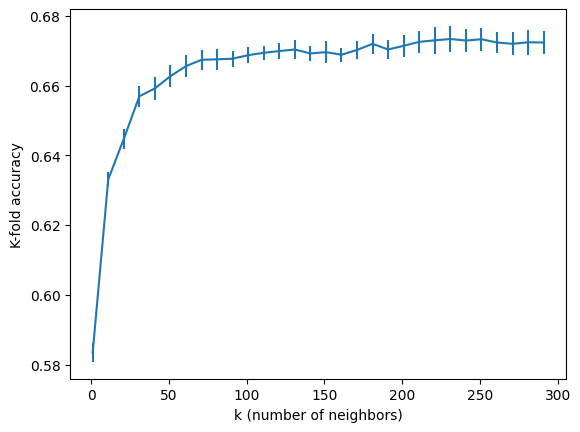

In [67]:
plt.errorbar(x=k_list, y=acc_list.mean(axis=1), yerr=acc_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("k (number of neighbors)");
plt.ylabel("K-fold accuracy");

Using this, we can find a better choice for k (number of neighbors):

In [68]:
best_k = k_list[np.argmax(acc_list.mean(axis=1))]
print(best_k)

231


Now, let’s re-run our KNN algorithm using the entire training set and this `best_k` number of neighbors, and check its accuracy?

In [69]:
r_matrix = np.random.random(size=(distances_custom.shape))
nn_lists = np.array([np.lexsort((r, row))[:best_k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [70]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.6792397660818713

### Summarizing our basic classifier

Our basic classifier:

-   uses three features (age, race, and education) to predict a respondent’s vote
-   doesn’t mind if there are NaNs in the data (unlike the `sklearn` implementation, which throws an error)
-   uses a random tiebreaker if there are multiple training samples with the same distance to the test sample
-   uses the number of neighbors with the best validation accuracy, according to K-fold CV.

But, there are some outstanding issues:

-   we have only used three features, out of many more available features.
-   the distance metric only cares about the degree of disagreement (difference) between two samples, and doesn’t balance it against the degree of agreement (similarity).

For this assignment, you will create an even better classifier by improving on those two issues.

## Create a better classifier

In the remaining sections of this notebook, you’ll need to fill in code to:

-   implement a custom distance metric
-   encode more features
-   implement feature selection or feature weighting
-   “train” and evaluate your final classifier, including K-Fold CV to select the best value for number of neighbors.

### Create a better distance metric

Your first task is to improve on the basic distance metric we used above. There is no one correct answer - there are many ways to compute a distance - but for full credit, your distance metric should satisfy the following criteria:

1.  if two samples are identical, the distance between them should be zero.
2.  as the extent of *difference* between two samples increases, the distance should increase.
3.  as the extent of *similarity* between two samples increases, the distance should decrease.
4.  if in a pair of samples one or both have a NaN value for a given feature, the similarity or difference of this feature is *unknown*. Your distance metric should compute a smaller distance for a pair of samples with many similarities (even if there is some small difference) than for a pair of samples with mostly unknown similarity.

You should also avoid explicit `for` loops inside the `custom_distance` function - use efficient `numpy` functions instead. Note that `numpy` includes many functions that are helpful when working with arrays that have NaN values, including mathematical functions like [sum](https://numpy.org/doc/stable/reference/generated/numpy.nansum.html), [product](https://numpy.org/doc/stable/reference/generated/numpy.nanprod.html), [max](https://numpy.org/doc/stable/reference/generated/numpy.nanmax.html) and [min](https://numpy.org/doc/stable/reference/generated/numpy.nanmin.html), and logic functions like [isnan](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html).

#### Implement your distance metric

In [72]:
# TODO - implement distance metric

def custom_distance(a, b):
  diffs = np.nan_to_num(np.subtract(a, b))
  distances_diff = np.sum(np.abs(diffs), axis=1)

  similarity_matrix = np.where(np.isnan(a) | np.isnan(b), np.nan, np.equal(a, b).astype(int))

  num_similarities = np.nansum(similarity_matrix, axis=1)

  total_comparable_features = np.sum(~np.isnan(similarity_matrix), axis=1)

  distances = np.where(
      total_comparable_features > 0,
      distances_diff - num_similarities / total_comparable_features,
      distances_diff
  )

  return distances

#### Test cases for your distance metric

You can use these test samples to check your work. (But, your metric should also satisfy the criteria in general - not only for these specific cases!)

First criteria: if two samples are identical, the distance between them should be zero.

In [73]:
a = np.array([[0, 1, 0,      1, 0, 0.3]] )  # A0 - test sample
b = np.array([[0, 1, 0,      1, 0, 0.3]] )  # B0 - same as A0, should have 0 distance


In [74]:
distances_ex = np.zeros(shape=(len(a), len(b)))
for idx, a_i in enumerate(a):
  distances_ex[idx] = custom_distance(a_i, b)

print(distances_ex)

[[-1.]]


Second criteria: as the extent of *difference* between two samples increases, the distance should increase.

These should have *increasing* distance:

In [75]:
a = np.array([[0, 1, 0,      1, 0, 0.3]] )  # A0 - test sample
b = np.array([[0, 1, 0,      1, 0, 0.3],              # B0 - same as A0, should have 0 distance
              [0, 1, 0,      1, 0, 0.5],              # B1 - has one small difference, should have larger distance than B0
              [0, 1, 0,      1, 0, 1  ],              # B2 - has more difference, should have larger distance than B1
              [0, 0, 0,      1, 0, 0  ],              # B3 - has even more difference
              [1, 0, 1,      0, 1, 0  ]])             # B4 - has the most difference

In [76]:
distances_ex = np.zeros(shape=(len(a), len(b)))
for idx, a_i in enumerate(a):
  distances_ex[idx] = custom_distance(a_i, b)

print(distances_ex)

[[-1.   -0.63 -0.13  0.63  5.3 ]]


These should have *decreasing* distance:

In [77]:
a = np.array([[0, 1, 0, 1, 0, 1]] )            # A0 - test sample
b = np.array([[1, 0, 1, 0, 1, 0],              # B0 - completely different, should have large distance
              [1, 0, 1, 0, 1, np.nan],         # B1 - less difference than B0, should have less distance
              [1, 0, 1, 0, np.nan, np.nan]])   # B2 - even less difference than B1, should have less distance

In [78]:
distances_ex = np.zeros(shape=(len(a), len(b)))
for idx, a_i in enumerate(a):
  distances_ex[idx] = custom_distance(a_i, b)

print(distances_ex)

[[6. 5. 4.]]


Third criteria: as the extent of *similarity* between two samples increases, the distance should decrease.

These should have *increasing* distance:

In [79]:
a = np.array([[0, 1, 0, 1, 0, 0.3]] )  # A0 - test sample
b = np.array([[0, 1, 0, 1, 0, 0.3],              # B0 - same as A0, should have 0 distance
              [0, 1, 0, 1, 0, np.nan],           # B1 - has less similarity than B0, should have larger distance
              [0, 1, 0, 1, np.nan, np.nan],      # B2 - has even less similarity, should have larger distance
              [0, np.nan, np.nan, np.nan, np.nan, np.nan]])     # B3 - has least similarity, should have larger distance

In [80]:
distances_ex = np.zeros(shape=(len(a), len(b)))
for idx, a_i in enumerate(a):
  distances_ex[idx] = custom_distance(a_i, b)

print(distances_ex)

[[-1. -1. -1. -1.]]


Fourth criteria: if in a pair of samples one or both have a NaN value for a given feature, the similarity or difference of this feature is *unknown*. Your distance metric should compute a smaller distance for a pair of samples with many similarities (even if there is some small difference) than for a pair of samples with mostly unknown similarity.

These should have *increasing* distance:

In [81]:
a = np.array([[0, np.nan, 0, 1, np.nan, 0.3]] )  # A0 - test sample
b = np.array([[0, np.nan, 0, 1, 0,      0.5],                # B0 - three similar features, one small difference
              [0, np.nan, np.nan, np.nan, np.nan, np.nan]])  # B1 - much less similarity than B0, should have larger distance


In [82]:
distances_ex = np.zeros(shape=(len(a), len(b)))
for idx, a_i in enumerate(a):
  distances_ex[idx] = custom_distance(a_i, b)

print(distances_ex)

[[-0.55 -1.  ]]


### Encode more features

Our basic classifier used three features: age, race, and education. But there are many more features in this data that may be predictive of vote:

-   More demographic information: `INCOME16GEN`, `MARRIED`, `RELIGN10`, `ATTEND16`, `LGBT`, `VETVOTER`, `SEX`
-   Opinions about political issues and about what factors are most important in determining which candidate to vote for: `TRACK`, `SUPREME16`, `FINSIT`, `IMMWALL`, `ISIS16`, `LIFE`, `TRADE16`, `HEALTHCARE16`, `GOVTDO10`, `GOVTANGR16`, `QLT16`, `ISSUE16`, `NEC`

in addition to the features `AGE`, `RACE`, and `EDUC12R`.

You will try to improve the model by adding some of these features.

(Note that we will *not* use questions that directly ask the participants how they feel about individual candidates, or about their party affiliation or political leaning. These features are a close proxy for the target variable, and we’re going to assume that these are not available to the model.)

Refer to the PDF documentation to see the question and the possible answers corresponding to each of these features. You may also choose to do some exploratory data analysis, to help you understand these features better.

For your convenience, here are all the possible answers to those survey questions:

In [83]:
features = ['INCOME16GEN', 'MARRIED', 'RELIGN10', 'ATTEND16', 'LGBT', 'VETVOTER',
            'SEX', 'TRACK', 'SUPREME16',  'FINSIT', 'IMMWALL', 'ISIS16', 'LIFE',
            'TRADE16', 'HEALTHCARE16', 'GOVTDO10', 'GOVTANGR16', 'QLT16',
            'ISSUE16', 'NEC']

for f in features:
  print(f)
  print(df[f].value_counts())
  print("***************************************************")


INCOME16GEN
INCOME16GEN
$50,000-$99,999      2606
$100,000-$199,999    2015
$30,000-$49,999      1586
Under $30,000        1385
$250,000 or more      495
$200.000-$249,999     350
Name: count, dtype: int64
***************************************************
MARRIED
MARRIED
Yes    5182
No     3611
Name: count, dtype: int64
***************************************************
RELIGN10
RELIGN10
Other christian    1996
Catholic           1792
Protestant         1784
Other               577
Jewish              196
Mormon              114
Muslim               71
Name: count, dtype: int64
***************************************************
ATTEND16
ATTEND16
Once a week or more    1411
A few times a year     1206
Never                   916
A few times a month     697
Name: count, dtype: int64
***************************************************
LGBT
LGBT
No     4007
Yes     194
Name: count, dtype: int64
***************************************************
VETVOTER
VETVOTER
No     3673
Yes     56

It is up to you to decide which features to include in your model. However, you must encode at least eight features, including:

-   at least four features that are encoded using an ordinal encoder because they have a logical order (and you should include an explicit mapping for these), and
-   at least four features that are encoded using one-hot encoding because they have no logical order.

Binary features - features that can take on only two values - “count” toward either category.

(If you decide to use the features I used above, they do “count” as part of the four. For example, you could use age, education, and two additional ordinal-encoded features, and race and three other one-hot-encoded features.)

#### Encode ordinal features

In the following cells, prepare your ordinal encoded features as demonstrated in the “Prepare data \> Encode ordinal features” section earlier in this notebook.

Use at least four features that are encoded using an ordinal encoder. (You can choose which features to include, but they should be either binary features, or features for which the values have a logical ordering that should be preserved in the distance computations!)

Also:

-   Save the ordinal-encoded columnns in a data frame called `df_enc_ord`.
-   You should explicitly specify the mappings for these, so that you can be sure that they are encoded using the correct logical order.
-   For some questions, there is also an “Omit” answer - if a respondent left that question blank on the questionnaire, the value for that question will be “Omit”. Since “Omit” has no logical place in the order, we’re going to treat these as missing values: don’t include “Omit” in your `mapping_ord` dictionary, and then these Omit values will be encoded as NaN.
-   Make sure to scale each column to the range 0-1, as demonstrated in the “Prepare data \> Encode ordinal features” section earlier in this notebook.

In [84]:
# TODO - encode ordinal features

mapping_ord = {
    'INCOME16GEN': {
        'Under $30,000': 0,
        '$30,000-$49,999': 1,
        '$50,000-$99,999': 2,
        '$100,000-$199,999': 3,
        '$200.000-$249,999': 4,
        '$250,000 or more': 5
    },
    'ATTEND16': {
        'Never': 0,
        'A few times a year': 1,
        'A few times a month': 2,
        'Once a week or more': 3
    },
    'SUPREME16': {
        'Not a factor at all': 0,
        'A minor factor': 1,
        'An important factor': 2,
        'The most important factor': 3
    },
    'FINSIT': {
        'Worse today': 0,
        'About the same': 1,
        'Better today': 2
    }
}

features_to_encode = list(mapping_ord.keys())

df_enc_ord = df[features_to_encode].copy()

for col in features_to_encode:
    df_enc_ord[col] = df_enc_ord[col].map(mapping_ord[col])

def min_max_scale(series):
    return (series - series.min()) / (series.max() - series.min())

df_enc_ord = df_enc_ord.apply(min_max_scale)

print(df_enc_ord.head())



   INCOME16GEN  ATTEND16  SUPREME16  FINSIT
0          0.0       NaN        NaN     NaN
1          0.2       NaN        NaN     NaN
2          0.4       NaN        NaN     NaN
3          0.4       NaN        NaN     NaN
4          0.6       NaN        NaN     NaN


Look at the encoded data to check your work:

In [85]:
df_enc_ord.describe()

,INCOME16GEN,ATTEND16,SUPREME16,FINSIT
count,8437.000000,4230.000000,4338.000000,4307.000000
mean,0.396302,0.538455,0.601352,0.530532
std,0.266629,0.385464,0.313631,0.386649
min,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.333333,0.333333,0.000000
50%,0.400000,0.333333,0.666667,0.500000
75%,0.600000,1.000000,0.666667,1.000000
max,1.000000,1.000000,1.000000,1.000000


#### Encode categorical features

In the following cells, prepare your categorical encoded features as demonstrated in the “Prepare data \> Encode categorical features” section earlier in this notebook.

Use at least four features that are encoded using an categorical encoder. (You can choose which features to include, but they should be either binary features, or features for which the values do *not* have a logical ordering that should be preserved in the distance computations!)

Also:

-   Save the categorical-encoded columnns in a data frame called `df_enc_oh`.
-   For some questions, there is also an “Omit” answer - if a respondent left that question blank on the questionnaire, the value for that question will be “Omit”. We’re going to treat these as missing values. Before encoding the NaN values, you should drop the column corresponding to the “Omit” value from the data frame.

In [91]:
# TODO - encode categorical features

categorical_features = ['MARRIED', 'RELIGN10', 'LGBT', 'VETVOTER']

df_cat = df[categorical_features].copy()

df_enc_oh = pd.get_dummies(df_cat, prefix_sep='_')

df_enc_oh.drop(['ISSUE16_Omit', 'QLT16_Omit', 'TRACK_Omit', 'IMMWALL_Omit', 'GOVTDO10_Omit'],
               axis=1, inplace=True, errors='ignore')


for feature in categorical_features:
    dummy_cols = [col for col in df_enc_oh.columns if col.startswith(feature + '_')]
    mask = df_cat[feature].isna()
    df_enc_oh.loc[mask, dummy_cols] = np.nan

print(df_enc_oh.head())


  MARRIED_No MARRIED_Yes RELIGN10_Catholic RELIGN10_Jewish RELIGN10_Mormon  \
0      False        True               NaN             NaN             NaN   
1      False        True               NaN             NaN             NaN   
2      False        True               NaN             NaN             NaN   
3       True       False               NaN             NaN             NaN   
4       True       False               NaN             NaN             NaN   

  RELIGN10_Muslim RELIGN10_Other RELIGN10_Other christian RELIGN10_Protestant  \
0             NaN            NaN                      NaN                 NaN   
1             NaN            NaN                      NaN                 NaN   
2             NaN            NaN                      NaN                 NaN   
3             NaN            NaN                      NaN                 NaN   
4             NaN            NaN                      NaN                 NaN   

  LGBT_No LGBT_Yes VETVOTER_No VETVOTER_Yes 

<ipython-input-91-f4fc3a961352>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_enc_oh.loc[mask, dummy_cols] = np.nan
<ipython-input-91-f4fc3a961352>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_enc_oh.loc[mask, dummy_cols] = np.nan
<ipython-input-91-f4fc3a961352>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_enc_oh.loc[mask, dummy_cols] = np.nan
<ipython-input-91-f4fc3a961352>:16: FutureWarning: Setting an item of incompatible dtype is deprecated 

#### Stack columns

Now, we’ll create a combined data frame with all of the encoded features:

In [92]:
X = pd.concat([df_enc_oh, df_enc_ord], axis=1)

In [93]:
X.describe()

,INCOME16GEN,ATTEND16,SUPREME16,FINSIT
count,8437.000000,4230.000000,4338.000000,4307.000000
mean,0.396302,0.538455,0.601352,0.530532
std,0.266629,0.385464,0.313631,0.386649
min,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.333333,0.333333,0.000000
50%,0.400000,0.333333,0.666667,0.500000
75%,0.600000,1.000000,0.666667,1.000000
max,1.000000,1.000000,1.000000,1.000000


### Feature selection or feature weighting

Because the K nearest neighbor classifier weights each feature equally in the distance metric, including features that are not relevant for predicting the target variable can actually make performance worse.

To improve performance, you could either:

-   use a subset of features that are most important, or
-   use feature weights, so that more important features are scaled up and less important features are scaled down.

Feature selection has another added benefit - if you use fewer features, than you also get a faster inference time.

There are many options for feature selection or feature weighting, and you can choose anything that seems reasonable to you - there isn’t one right answer here! But, you will have to explain and justify your choice. In our lesson on feature selection/weighting, we discussed two parts to the problem of identifying the best subset of features:

-   **Search**: you will have to describe the search strategy you use to determine the features or feature subsets to evaluate.
-   **Evaluate**: you will have to describe the approach you use to evaluate the “goodness” of a feature or feature subset. Since this dataset has the added complication of missing values, you should also make sure to explain how you handle missing values in your evaluation.

And, you will have to describe the approach you used to select the best **number** of features to include or best **size** of feature subset (if you are using feature selection, not feature weighting).

For full credit, you will have to convince me that the approach you selected is a good match for (1) the data, and (2) the learning model.

In the following cell, implement feature selection or feature weighting, and return the results in `X_trans`:

-   If you use feature selection, `X_trans` should have all of the rows of `X`, but only a subset of its columns. You should create a variable `feat_inc` which is a list of all of the features you want to include in the model.
-   If you use feature weighting, `X_trans` should have the same dimensions of `X`, but instead of each column being in the range 0-1, each column will be scaled according to its importance (more important features will be scaled up, less important features will be scaled down). You should create a variable `feat_wt` which has a weight for every feature in `X`. Then, you’ll multiply `X` by `feat_wt` to get `X_trans`.

Some important notes:

-   The goal is to write code to find the feature selection or feature weighting, not to find it by manual inspection! Don’t hard-code any values.
-   Although `X_trans` will include all rows of the data, you should not use the test data in the process of finding `feat_inc` or `feat_wt`! Feature selection and feature weighting are considered part of model fitting, and so only the training data may be used in this process.
-   For the “search” part of the optimization, you should not use any `sklearn` function or equivalent from another library - write pure Python+numpy code to implement the search yourself. For the “evaluate” part of the optimization, you are free to use an `sklearn` function, but make sure you understand what it does and are sure it is a good fit for the data and the model!

In [95]:
# TODO - feature selection OR feature weighting
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

all_features = list(X.columns)
feat_inc = []
remaining_features = all_features.copy()
best_score = 0.0
improvement_threshold = 0.001

while remaining_features:
    best_feature = None
    best_candidate_score = best_score

    for feature in remaining_features:
        candidate_features = feat_inc + [feature]
        X_candidate = X[candidate_features].dropna()
        y_candidate = y.loc[X_candidate.index]

        if X_candidate.shape[0] < 10:
            continue

        knn = KNeighborsClassifier(n_neighbors=5)
        scores = cross_val_score(knn, X_candidate, y_candidate, cv=5)
        candidate_score = scores.mean()

        if candidate_score > best_candidate_score:
            best_candidate_score = candidate_score
            best_feature = feature

    if best_feature is not None and (best_candidate_score - best_score) > improvement_threshold:
        feat_inc.append(best_feature)
        remaining_features.remove(best_feature)
        best_score = best_candidate_score
        print(f"Added feature '{best_feature}' with CV score: {best_score:.3f}")
    else:
        break

X_trans = X[feat_inc]

print("\nFinal selected features:", feat_inc)

Added feature 'VETVOTER_No' with CV score: 0.557
Added feature 'FINSIT' with CV score: 0.592

Final selected features: ['VETVOTER_No', 'FINSIT']


Check your work:

In [96]:
X_trans.describe()

,FINSIT
count,4307.000000
mean,0.530532
std,0.386649
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


#### TODO - describe your approach to feature selection or feature weighting

In a text cell, describe **in detail** the approach you used for feature selection or feature weighting. Your answer should include the following parts, in paragraph form:

-   **Part 1: Search**: describe the search strategy you use to determine the features or feature subsets to evaluate. Is the approach you chose guaranteed to evaluate the optimal feature subset? How many feature subsets do you need to consider as part of your approach?

I used forward selection, a method that starts with no features and adds one at a time based on which improves accuracy the most. This is not guaranteed to find the best possible subset because it doesn’t check all feature combinations. Instead, it looks at a smaller number of possible feature sets, making it much faster than testing every combination.

-   **Part 2: Evaluate**: describe the approach you use to evaluate the “goodness” of a feature or feature subset. Did you use a filter method or a wrapper method? What was the scoring function or model you used to evaluate the “goodness” of a feature or feature subset, and why? And since this dataset has the added complication of missing values, you should also make sure to explain how you handle missing values in your evaluation.

I used a wrapper method with K-Nearest Neighbors to test how well each feature subset performs. I measured accuracy using 5-fold cross-validation choosing features that improved the model the most.

-   **Part 3: Number/size**: if you are using feature selection, not feature weighting: Describe the approach you used to select the best **number** of features to include or best **size** of feature subset.

Also explain: Why is the approach you chose well suited for *this data* and *this model*? And, what are some disadvantages or limitations of the approach you chose?

I kept adding features until no new feature improved accuracy by a meaningful amount. Once I reached that point, I stopped adding features and used the selected subset.

This method works well because it directly optimizes for KNN, which relies on distances between points. It also reduces computation by selecting only the most important features. The downside is that it might miss good combinations of features since it only adds one at a time.


### Evaluate final classifier

Finally, you’ll repeat the process of finding the best number of neighbors using K-fold CV, with your “transformed” data (`X_trans`) and your new custom distance metric.

Then, you’ll evaluate the performance of your model on the *test* data, using that optimal number of neighbors.

In [ ]:
# TODO - evaluate - pre-compute distance matrix of training vs. training data

distances_kfold = ...


In [ ]:
# TODO - evaluate - use K-fold CV, fill in acc_list

n_fold = 5
k_list = np.arange(1, 301, 10)
n_k = len(k_list)
acc_list = np.zeros((n_k, n_fold))

# use this random state so your results will match the auto-graders'
kf = KFold(n_splits=5, shuffle=True, random_state=3)

for isplit, idx_k in enumerate(kf.split(idx_tr)):

  # Outer loop

  for idx_k, k in enumerate(k_list):

    # Inner loop

    acc_list[idx_k, isplit] = ...

See how the validation accuracy changes with number of neighbors:

In [ ]:
plt.errorbar(x=k_list, y=acc_list.mean(axis=1), yerr=acc_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("k (number of neighbors)");
plt.ylabel("K-fold accuracy");

Find the best choice for k (number of neighbors) using the “highest validation accuracy” rule:

In [ ]:
# TODO - evaluate - find best k
best_k = ...

Finally, re-run our KNN algorithm using the entire training set and this `best_k` number of neighbors. Check its accuracy on the test data.

In [ ]:
# TODO - evaluate - find accuracy
# compute distance matrix for test vs. training data
# use KNN with best_k to find y_pred for test data
y_pred = ...
# compute accuracy
acc = ...

In [ ]:
print(acc)